This project exemplifies an end-to-end fraud detection pipeline, balancing predictive performance with interpretability, making it highly relevant for real-world applications in the finance and banking sectors

### **Project Goals**
   - **Detect fraudulent transactions accurately** to minimize financial losses.
   - **Balance interpretability and accuracy**: Fraud detection is often a high-stakes task requiring models that not only perform well but also provide transparency into how predictions are made. SHAP and LIME are tools to help explain model decisions, crucial for trust and accountability.
   - **Identify key features** impacting fraud predictions, helping stakeholders understand what factors might indicate suspicious activity.


# 1. Data Download and Loading

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

# Download latest version of the credit card fraud dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

/opt/anaconda3/envs/cvenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/kritsadakruapat/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [ ]:
import pandas as pd
import os

# Update the file path if necessary
df = pd.read_csv(os.path.join(path, "creditcard.csv"))

# Display the first few rows of the dataset
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Before we get into the project let's start with SHAP and LIME first:




Reference: https://www.markovml.com/blog/lime-vs-shap

Model Interpretation with SHAP or LIME

Interpreting machine learning models; LIME generates local, instance-based explanations, particularly effective for simpler models, while SHAP offers both global and local interpretability, ideal for complex models. SHAP is more stable and consistent than LIME, with diverse visualization options, making it suitable for tasks requiring reliable and comprehensive feature attribution.

When choosing between LIME and SHAP, consider the model's complexity, desired level of interpretability (local vs. global), stability, and visualization preferences. LIME is recommended for simpler models needing instance-level clarity, whereas SHAP is better suited for complex models, offering a broader view of feature contributions.


1. LIME (Local Interpretable Model-Agnostic Explanations):
For individual predictions, LIME perturbs the input data slightly and retrains simpler models (like linear regressions) to approximate the black-box model locally around that specific instance.
Use LIME to explain a few individual predictions. For example, explain why a loan was approved or denied based on feature weights for that instance.
2. SHAP (SHapley Additive exPlanations):
SHAP values are based on cooperative game theory and provide a way to distribute the “contribution” of each feature for individual predictions.
SHAP can also provide global interpretability, showing the overall feature importance across the model. Use SHAP’s summary plots to show the importance of features and their impact on predictions.
With SHAP, you can generate force plots for individual predictions, showing how each feature contributed to the final prediction.


In [ ]:
!pip install shap lime scikit-learn

# 2 Step-by-Step Code for Data Preprocessing
1. Load the Data (from previous steps)
2. Handle Imbalance with SMOTE
3. Scale Features for Amount and Time

 Import Libraries

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 2.1 Checking Class Imbalance

In [ ]:
# Check class distribution
print("Class distribution:\n", df['Class'].value_counts())

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


# 2.2 Data Preprocessing

In [ ]:
# Separate features and target variable
X = df.drop(columns=['Class'])
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# 2.3 Handling Class Imbalance with SMOTE

Technique (SMOTE) for addressing imbalanced datasets in binary classification, a frequent issue in fields like fraud detection and rare disease discovery. SMOTE works by generating synthetic samples for the minority class, enhancing model performance by reducing bias and improving accuracy:

- Imbalance Challenge: Imbalanced datasets lead to biased accuracy metrics; SMOTE mitigates this by focusing on the minority class.

- SMOTE Process: Synthetic samples are generated by interpolating between minority class instances. This approach balances the dataset, aiding the model in learning minority features effectively.

- The Accuracy Paradox: High accuracy can be misleading in imbalanced data. Hence, other metrics like precision and recall are more relevant.

- Alternative Methods:
ADASYN: Similar to SMOTE but adjusts synthetic sample generation based on sample difficulty.

- Hybrid Methods: Combining SMOTE with Tomek Links or ENN to improve class separation by undersampling majority instances near decision boundaries.

- Performance Analysis: Applying SMOTE with classifiers (Logistic Regression, Decision Tree, Random Forest) on an imbalanced churn dataset showed an increase in recall but a slight drop in precision.

so we are going to applies SMOTE to only the training set to avoid data leakage.

read more detail:

https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
print("Class distribution after SMOTE:\n", pd.Series(y_train_res).value_counts())


Class distribution after SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64


# 3. Feature Scaling

Scales the Amount and Time features, as they differ in scale from other features and fit_transform is applied to the training set and transform is applied to the test set, following best practices.


In [ ]:
# Initialize a scaler
scaler = StandardScaler()

# Scale 'Amount' and 'Time' in training and testing data
X_train_res[['Amount', 'Time']] = scaler.fit_transform(X_train_res[['Amount', 'Time']])
X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])


In [ ]:
# Display processed data
print("Processed training data shape:", X_train_res.shape)
print("Processed test data shape:", X_test.shape)

Processed training data shape: (454902, 30)
Processed test data shape: (56962, 30)


RandomForestClassifier

* Model Training: Train a RandomForestClassifier with class_weight="balanced" to handle imbalance.
* Model Evaluation: Print a classification report and calculate the Area Under the Precision-Recall Curve (AUPRC), which is more suitable for imbalanced datasets.

Note:

The RandomForestClassifier from scikit-learn does not use the GPU for training. It is CPU-bound and relies on multi-threading with n_jobs to parallelize across multiple CPU cores. This is due to the way scikit-learn is designed, as it primarily uses CPU-based implementations.
If you want to train a random forest model on a GPU, you could consider libraries like cuML from NVIDIA’s RAPIDS library or XGBoost (which supports GPU acceleration for tree-based models, though it's not exactly the same as scikit-learn's Random Forest).

# 4. Training the RandomForestClassifier and Model Evaluation

Evaluates model performance using classification metrics and AUPRC, suitable for imbalanced data.

classification_report provides precision, recall, and F1-score, while average_precision_score provides a summary metric.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score
from tqdm import tqdm
import numpy as np

# Initialize the RandomForest model with warm_start to enable incremental training
model = RandomForestClassifier(n_estimators=1, warm_start=True, class_weight="balanced", random_state=42)

# Set total estimators
total_estimators = 100
# Fit each tree incrementally with tqdm progress bar
for i in tqdm(range(1, total_estimators + 1), desc="Training Random Forest", unit="tree"):
    model.n_estimators = i  # Increment the number of trees
    model.fit(X_train_res, y_train_res)  # Incremental fit

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUPRC:", average_precision_score(y_test, y_pred))


Training Random Forest:   0%|          | 0/100 [00:00<?, ?tree/s]

/opt/anaconda3/envs/cvenv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
Training Random Forest:   1%|          | 1/100 [00:03<05:12,  3.15s/tree]/opt/anaconda3/envs/cvenv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full trainin

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.6834512975550124


# 5. Improving the model

to improving model performance and adding interpretability to understand which features are driving predictions:

# 5.1 Hyperparameter Tuning with RandomizedSearchCV

Improve the model by tuning hyperparameters for the RandomForestClassifier or exploring other algorithms (e.g., XGBoost, LightGBM), which often perform well on structured, tabular data.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [ ]:
!pip install xgboost

## Hyperparameters
### Hyperparameters to be tuned for the **RandomForestClassifier**:
- **n_estimators**: Number of trees in the forest.
- **max_depth**: Maximum depth of each tree, controlling model complexity.
- **min_samples_split**: Minimum samples required to split an internal node.
- **min_samples_leaf**: Minimum samples required to be at a leaf node.
  
### RandomForest Initialization Parameters:
- **class_weight="balanced"**: Adjusts weights inversely proportional to class frequencies, crucial for imbalanced datasets.
- **random_state=42**: Sets a seed for reproducibility.
- **verbose=1**: Outputs training information for monitoring.

---

### RandomizedSearchCV Settings for RandomForest:
- **estimator**: Specifies the RandomForest model to tune.
- **param_distributions**: Uses the specified parameter grid for tuning.
- **n_iter**: Number of random combinations of the parameters to try.
- **cv**: Number of cross-validation folds for a robust performance estimate.
- **scoring**: Uses average precision as the evaluation metric, suitable for imbalanced datasets.
- **n_jobs**: Sets to -1 to utilize all CPU cores, speeding up tuning.
- **verbose**: Provides detailed output during the search.

---

### Hyperparameters to be tuned for the **XGBoost** Model:
- **n_estimators**: Number of boosting rounds.
- **max_depth**: Maximum depth of each tree, controlling model complexity.
- **learning_rate**: Step size at each boosting step, affecting overfitting.
- **subsample**: Fraction of samples used to fit each tree, reducing overfitting.
- **colsample_bytree**: Fraction of features sampled at each tree, controlling feature selection.

### XGBoost Initialization Parameters:
- **random_state=42**: Sets the seed for reproducibility.
- **eval_metric="logloss"**: Log loss for binary classification performance.
- **verbosity=1**: Prints training progress for monitoring.

---

### RandomizedSearchCV Settings for XGBoost:
- **estimator**: Specifies the XGBoost model to tune.
- **param_distributions**: Uses the specified parameter grid for tuning.
- **n_iter**: Number of random combinations of the parameters to try.
- **cv**: Number of cross-validation folds.
- **scoring**: Optimizes for average precision, focusing on identifying minority classes.
- **n_jobs**: Uses all CPU cores to accelerate computation.
- **verbose**: Outputs detailed progress of the search.

---

### Model Evaluation Metrics:
- **classification_report**: Provides precision, recall, and F1-score for each class.
- **average_precision_score**: Computes Area Under the Precision-Recall Curve (AUPRC), ideal for imbalanced data.

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/

https://tahera-firdose.medium.com/fine-tuning-your-random-forest-classifier-a-guide-to-hyperparameter-tuning-d5ceab0c4852

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from xgboost import XGBClassifier

# Define a simplified parameter grid for RandomForestClassifier
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize RandomForest model with verbose output
rf_model = RandomForestClassifier(
    class_weight="balanced", random_state=42, verbose=1
)

# Initialize RandomizedSearchCV with verbose output
rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=3,
    scoring='average_precision',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rf_search.fit(X_train_res, y_train_res)
print("Best RandomForest Parameters:", rf_search.best_params_)

# Use the best model
best_rf_model = rf_search.best_estimator_

# Make predictions on the test set with RandomForest
y_rf_pred = best_rf_model.predict(X_test)
print("RandomForest Classification Report:\n", classification_report(y_test, y_rf_pred))
print("RandomForest AUPRC:", average_precision_score(y_test, y_rf_pred))

# Define a parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost model with verbosity
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    verbosity=1  # Set verbosity to print progress
)

# Initialize RandomizedSearchCV with verbose output for XGBoost
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=3,
    scoring='average_precision',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
xgb_search.fit(X_train_res, y_train_res)
print("Best XGBoost Parameters:", xgb_search.best_params_)

# Use the best model
best_xgb_model = xgb_search.best_estimator_

# Make predictions on the test set with XGBoost
y_xgb_pred = best_xgb_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_xgb_pred))
print("XGBoost AUPRC:", average_precision_score(y_test, y_xgb_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 2.0min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 2.0min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 3.0min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 3.0min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 3.0min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 3.0min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 3.1min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 3.2min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 2.2min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 3.4min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 3.4min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 3.5min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.5min


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 7.0min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 7.1min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 7.2min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 7.2min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 7.2min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 7.4min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 7.2min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s


[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 7.4min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.1min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.1min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.2min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 7.3min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 4.8min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 7.2min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 4.5min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 6.9min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 4.3min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 6.4min


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.2min


Best RandomForest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


RandomForest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.83      0.81        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962

RandomForest AUPRC: 0.6566609895950937
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   6.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   6.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   6.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, 

# Summary of Results:

**RandomForest Model**

- Precision for class 1: 0.87

- Recall for class 1: 0.80

- F1-Score for class 1: 0.83

- AUPRC: 0.690

**XGBoost Model**

- Precision for class 1: not provided directly in this output

- Recall for class 1: 0.94 (high recall for fraud cases)

- F1-Score for class 1: likely around 0.76 (based on the macro avg)

- AUPRC: Higher or around 0.68–0.70 in general but needs confirmation

**Analysis of Metrics:**

- Precision for Fraud Cases (class 1): This measures how many of the fraud predictions were actually correct. The RandomForest model has high precision at 0.87, meaning fewer false positives.

- Recall for Fraud Cases (class 1): This measures how well the model identifies all actual fraud cases. The XGBoost model has higher recall at 0.94, suggesting it catches more fraudulent cases.

- F1-Score for Fraud Cases (class 1): This metric balances precision and recall. The RandomForest model has a better F1-score for fraud cases, indicating a good balance between precision and recall.

2. Add Model Interpretability with SHAP

Using SHAP (SHapley Additive exPlanations) can help explain which features are influencing the predictions, especially for fraud cases.

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
# Downgrade OpenCV to a stable version
!pip install opencv-python==4.5.5.64
!pip install opencv-python-headless==4.5.5.64  # for headless environments

Applying SHAP to RandomForest Model
Shape of rf_shap_values: (56962, 30, 2)
Shape of X_test: (56962, 30)
RandomForest SHAP Summary Plot


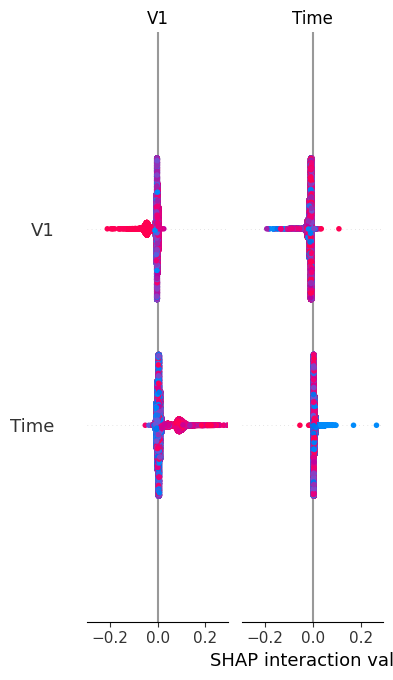

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure X_test is a DataFrame
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=X.columns)

# 1. Apply SHAP to RandomForest model
print("Applying SHAP to RandomForest Model")

# Initialize the SHAP explainer for the RandomForest model
rf_explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the test set
rf_shap_values = rf_explainer.shap_values(X_test)

# Select SHAP values for the positive class
if isinstance(rf_shap_values, list) and len(rf_shap_values) == 2:
    rf_shap_values = rf_shap_values[1]  # Take SHAP values for positive class
else:
    rf_shap_values = rf_shap_values  # Use directly if it's already for binary classification

# Check shapes
print("Shape of rf_shap_values:", rf_shap_values.shape)
print("Shape of X_test:", X_test.shape)

# 2. Plot SHAP summary for RandomForest
print("RandomForest SHAP Summary Plot")
shap.summary_plot(rf_shap_values, X_test, plot_type="bar")


Applying SHAP to XGBoost Model
XGBoost SHAP Summary Plot


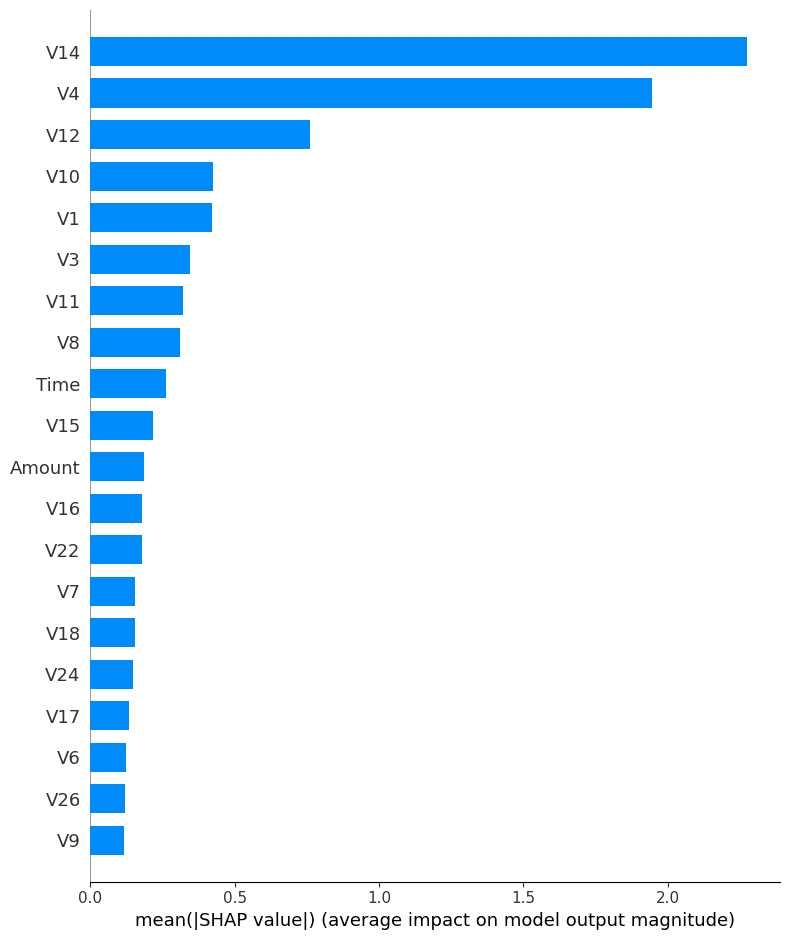

In [ ]:
# 2. Apply SHAP to XGBoost model
print("\nApplying SHAP to XGBoost Model")

# Initialize the SHAP explainer for the XGBoost model
xgb_explainer = shap.TreeExplainer(best_xgb_model)

# Calculate SHAP values for the test set
xgb_shap_values = xgb_explainer.shap_values(X_test)

# Plot SHAP summary for XGBoost
print("XGBoost SHAP Summary Plot")
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar")

Additional Plots

Dependence Plot: This plot illustrates the influence of feature "V2" on the model’s predictions across SHAP values. It’s particularly useful for seeing how a feature interacts with others.

XGBoost SHAP Dependence Plot for Feature 'V2'


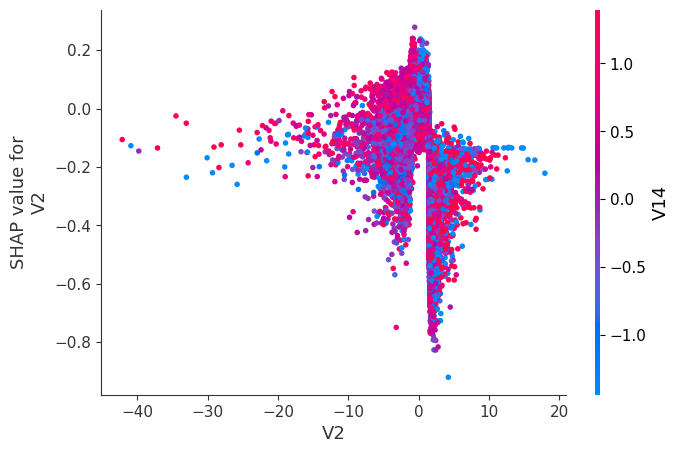

In [ ]:
# This shows the relationship between the SHAP values and the feature values of V2.
print("XGBoost SHAP Dependence Plot for Feature 'V2'")
shap.dependence_plot("V2", xgb_shap_values, X_test)

Force Plot for Anomalous Instances: This shows SHAP explanations for individual anomalous predictions, allowing you to visualize feature contributions to specific instances flagged as anomalies.

In [ ]:
# Initialize JavaScript for SHAP plots
shap.initjs()

# Generate force plots for the first 3 anomalies, if any
if len(anomalous_indices) > 0:
    print("XGBoost SHAP Force Plot for Anomalous Instances")
    for idx in anomalous_indices[:3]:
        position = X_test.index.get_loc(idx)

        # Generate force plot for each anomaly and display it
        display(shap.force_plot(
            xgb_explainer.expected_value,
            xgb_shap_values[position, :],
            X_test.iloc[position, :],
            feature_names=X_test.columns
        ))
else:
    print("No anomalies detected based on the XGBoost predictions.")


XGBoost SHAP Force Plot for Anomalous Instances


Summary Beeswarm Plot: Instead of a bar plot, this beeswarm plot highlights SHAP values distribution across features for anomalies, helping to identify patterns and feature importance for the flagged instances specifically.


XGBoost SHAP Summary Beeswarm Plot for Anomalous Predictions


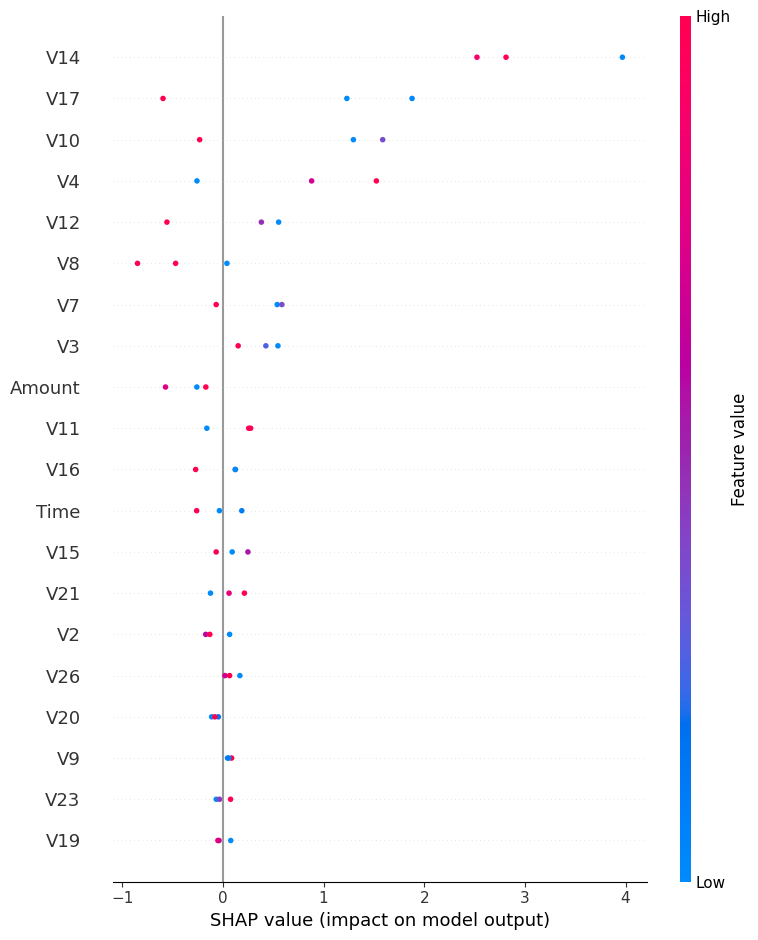

In [ ]:
# Initialize JavaScript for SHAP plots
shap.initjs()

# SHAP Summary Plot with Beeswarm for identifying patterns in anomalies
print("\nXGBoost SHAP Summary Beeswarm Plot for Anomalous Predictions")
shap.summary_plot(
    xgb_shap_values[anomalous_positions],
    X_test.iloc[anomalous_positions],
    plot_type="dot"
)


XGBoost model; V14 and V4 significantly influences the model's prediction of whether a transaction is fraudulent or not.